# Clasificacion supervisada RandomForest

In [5]:
# Importar paquete GEE
import ee
ee.Initialize()

## Filtro zona estudio mediante GEE

In [ ]:
# Agregar un shp GEE
zona_ee = ee.FeatureCollection("users/geoprocesamiento/Vichada_meta")

In [4]:
# Importar geemap
import geemap
Map = geemap.Map(basemap='ESRI')
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [6]:
geometria = zona_ee.geometry()
Map.centerObject(geometria,11)

In [5]:
Map.addLayer(zona_ee, {"color" : "green"},name = "Zona estudio")
Map

Map(bottom=8781415.333343506, center=[-8.39212494170386, -74.58093881185471], controls=(WidgetControl(options=…

## Seleccion de imagen

In [7]:
# Seleccionar una imagen Landsat8
img_L8 = ee.Image("LANDSAT/LC08/C01/T1_SR/LC08_003069_20190808")\
             .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7'],
                     ['BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2'])\
             .multiply(0.0001)\
             .clip(zona_ee)\
             .reproject(crs="EPSG:32719", scale = 30)

In [8]:
# Nombre de las bandas
img_L8.bandNames().getInfo()

['BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2']

In [9]:
# Simbologia escala 0 - 1
viz_es = {
    'bands': ['SWIR1','NIR','RED'],
    'min': 0.1,
    'max': 0.6,
    'gamma': 1.6
}

In [10]:
Map.addLayer(img_L8, viz_es,name = "Landsat8 RS")
Map

Map(bottom=281405.0, center=[-12.908744902436744, -69.9947155021359], controls=(WidgetControl(options=['positi…

In [11]:
Agua = (Map.user_rois).geometry()

In [16]:
features = []
for i in Agua.getInfo()["coordinates"]:
    F_agua = ee.Feature(ee.Geometry.Point(i), {"Clase" : 1,"Cobertura":"Agua"})
    features.append(F_agua)

In [19]:
Bosque = (Map.user_rois).geometry()

In [20]:
for i in Bosque.getInfo()["coordinates"]:
    F_Bosque = ee.Feature(ee.Geometry.Point(i), {"Clase" : 2, "Cobertura":"Bosque"})
    features.append(F_Bosque)

In [22]:
Pastizal = (Map.user_rois).geometry()

In [23]:
for i in Pastizal.getInfo()["coordinates"]:
    F_Pastizal = ee.Feature(ee.Geometry.Point(i), {"Clase" : 3, "Cobertura":"Pastizal"})
    features.append(F_Pastizal)

In [24]:
Suelo = (Map.user_rois).geometry()

In [25]:
for i in Suelo.getInfo()["coordinates"]:
    F_Suelo = ee.Feature(ee.Geometry.Point(i), {"Clase" : 4, "Cobertura":"Suelo"})
    features.append(F_Suelo)

In [27]:
# ROI Entrenamiento
ROI = ee.FeatureCollection(features)

In [28]:
Map.addLayer(ROI,{"color":"red"},"ROI")
Map

Map(bottom=140732.0, center=[-12.747516274952714, -69.82566833496095], controls=(WidgetControl(options=['posit…

In [29]:
# Crear random aleatorio en un campo random
samples = ROI.randomColumn('random', 2000)

In [30]:
# Obtener un FeatureCollection de datos ROI
set_datos = img_L8.sampleRegions(collection = samples,
                                 properties = ["Clase","random","Cobertura"],
                                 scale = 30,
                                 projection = None,
                                 tileScale = 1,
                                 geometries = True)

In [31]:
# Separar datos entrenamiento y validacion
split = 0.8  # Aproximadamente 80% de Entrenamiento, 20% de validacion
training = set_datos.filter(ee.Filter.lt('random', split))
testing = set_datos.filter(ee.Filter.gte('random', split))

## Exportar shapefile set datos

In [32]:
import os
ruta_archivos = r"E:\Teledeteccion_GEE\Python\Datos_Espaciales\Resultados"
os.chdir(ruta_archivos) # Cambiar ruta trabajo
os.getcwd() # Consultar ruta trabajo

'E:\\Teledeteccion_GEE\\Python\\Datos_Espaciales\\Resultados'

In [33]:
# Exportar shp
# Datos ROI completo
geemap.ee_to_shp(set_datos, 
                 filename = 'ROI_completo.shp')
# Datos ROI entrenamiento
geemap.ee_to_shp(training, 
                 filename = 'ROI_entrenamiento.shp')
# Datos ROI Validacion
geemap.ee_to_shp(testing, 
                 filename = 'ROI_validacion.shp')

Generating URL ...
Please wait ...
Data downloaded to E:\Teledeteccion_GEE\Python\Datos_Espaciales\Resultados\ROI_completo.shp
Generating URL ...
Please wait ...
Data downloaded to E:\Teledeteccion_GEE\Python\Datos_Espaciales\Resultados\ROI_entrenamiento.shp
Generating URL ...
Please wait ...
Data downloaded to E:\Teledeteccion_GEE\Python\Datos_Espaciales\Resultados\ROI_validacion.shp


## Parámetro clasificación RandomForest

In [35]:
# seleccionar las bandas
bandas_sel = ['BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2']

In [36]:
# Image classification
classifier = ee.Classifier.smileRandomForest(100).train(training, 'Clase', bandas_sel);

## Aplicar clasificación

In [37]:
# clasificación con el modelo entrenado
clasificacion_RF = img_L8.classify(classifier)

In [38]:
# Simbologia clasificacion
viz_clas = {
    'palette': ["blue","green", "#08e723", "red"],
    'min': 1,
    'max': 4
}

In [39]:
Map.addLayer(clasificacion_RF, viz_clas, name = "class_RF")
Map

Map(bottom=281519.0, center=[-12.98515498538087, -69.98119354248048], controls=(WidgetControl(options=['positi…

## Conversion de Shapefile a Pandas

In [40]:
dataframe = geemap.ee_to_pandas(set_datos)
dataframe.head()

,random,Cobertura,Clase,RED,BLUE,NIR,GREEN,SWIR1,SWIR2
0,0.965318,Agua,1,0.2024,0.0615,0.0878,0.1439,0.0040,0.0026
1,0.505567,Agua,1,0.2022,0.0617,0.0889,0.1434,0.0043,0.0026
2,0.133367,Agua,1,0.2021,0.0625,0.0887,0.1449,0.0050,0.0032
3,0.396335,Agua,1,0.2030,0.0625,0.0882,0.1449,0.0044,0.0024
4,0.030215,Agua,1,0.2031,0.0621,0.0893,0.1455,0.0051,0.0030


In [41]:
dataframe.to_csv("Coberta_ROI.csv")

In [42]:
lista_cobertura = dataframe["Cobertura"].unique()
lista_cobertura

array(['Agua', 'Bosque', 'Pastizal', 'Suelo'], dtype=object)

## Matriz de confusión y precisión

In [43]:
validation = testing.classify(classifier);
errorMatrix = validation.errorMatrix('Clase', 'classification');

In [44]:
Matriz = errorMatrix.getInfo()
Matriz

[[0, 0, 0, 0, 0],
 [0, 8, 0, 0, 0],
 [0, 0, 8, 1, 0],
 [0, 0, 0, 5, 0],
 [0, 0, 1, 0, 7]]

In [45]:
import pandas as pd
import numpy as np

In [46]:
trainCM = pd.DataFrame(np.asarray(Matriz), 
                       index=['Eliminar','Agua', 'Bosque', 'Pastizal', 'Suelo'], 
                       columns=['Eliminar','Agua', 'Bosque', 'Pastizal', 'Suelo'])
trainCM

,Eliminar,Agua,Bosque,Pastizal,Suelo
Eliminar,0,0,0,0,0
Agua,0,8,0,0,0
Bosque,0,0,8,1,0
Pastizal,0,0,0,5,0
Suelo,0,0,1,0,7


In [47]:
# Eliminar columna por etiqueta
trainCM_1 = trainCM.drop(labels = ["Eliminar"], axis = 1)

In [48]:
trainCM_2 = trainCM_1.drop(labels = ["Eliminar"], axis = 0)
trainCM_2

,Agua,Bosque,Pastizal,Suelo
Agua,8,0,0,0
Bosque,0,8,1,0
Pastizal,0,0,5,0
Suelo,0,1,0,7


In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

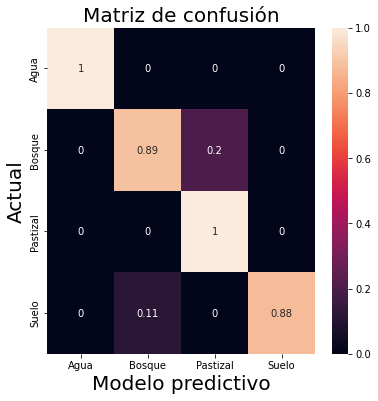

In [50]:
fig, ax = plt.subplots(1, figsize=(6,6))
sns.heatmap(trainCM_2/trainCM_2.sum(axis=1), annot=True)
ax.set_xlabel('Modelo predictivo', fontsize=20)
ax.set_ylabel('Actual', fontsize=20)
plt.title("Matriz de confusión", fontsize=20);

## Precisión de la clasificación

In [51]:
# precisión de la clasificación
print('Exactitud General:', errorMatrix.accuracy().getInfo());
print('Indice Kappa:', errorMatrix.kappa().getInfo())

Exactitud General: 0.9333333333333333
Indice Kappa: 0.9103139013452916


## Exportar resultados

In [52]:
os.getcwd()

'E:\\Teledeteccion_GEE\\Python\\Datos_Espaciales\\Resultados'

In [53]:
# Exportar en google drive
geemap.ee_export_image_to_drive(clasificacion_RF, 
                                description="LC08_003069_20190808"+"_Clas_RF2",
                                folder='GEE_Geomatica', 
                                region=geometria,
                                scale=30)

Exporting LC08_003069_20190808_Clas_RF2 ...
